In [2]:
import pandas as pd
import numpy as np
import os
import glob
import duckdb as db
import matplotlib.pyplot as plt

from helpers import load_full_df, delete_columns

import textblob as tx
from nltk.sentiment import SentimentIntensityAnalyzer
from langdetect import detect

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# from deep_translator import GoogleTranslator

# from transformers import AutoTokenizer, AutoModelForSequenceClassification
# from transformers import TextClassificationPipeline

# from sentence_transformers import SentenceTransformer


# tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
# model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
# pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer)

# model_st = SentenceTransformer('distiluse-base-multilingual-cased-v2')

CSV_DIR_STRING = 'data/csv_files/'
JSON_DIR_STRING = 'data/json_files/'
TARGET_COL_NAME = 'label'

In [3]:
def replacer(review: str) -> str:

    replace = {
                'á': 'a', 
                'é': 'e',
                'ớ': 'o',
                'ú': 'u',
                'Á': 'A',
                'É': 'E',
                'Ớ': 'O',
                'Ú': 'U'
            }
    
    for key in replace.keys():
        review = str(review).replace(key, replace[key])
    
    return review

def mx(x):

    if x == 'de':
        x = 3
    elif x == 'fr':
        x = 2
    elif x == 'en':
        x = 1
    else:
        x = np.random.randint(1, 3)
        
    return x

In [93]:
def preprocess(df, is_train=True, pipeline=None, model_st=None, do_nlp_pipeline=False):

    if is_train:
        df['vine'] = df['vine'].apply(lambda x: True if x == 'Y' else False)
        df['verified_purchase'] = df['verified_purchase'].apply(lambda x: True if x == 'Y' else False)
        # df['review_date'] = df['review_date'].astype(str)
        df['no_review_headline'] = df['review_headline'].isna()
        
        df.set_index('Unnamed: 0', drop=True, inplace=True)
        df.index.name = ''

        df['review_body'] = df.apply(lambda x: replacer(x['review_body']) if x['marketplace_id'] != 2 else x['review_body'], axis=1)
        df['review_headline'] = df.apply(lambda x: replacer(x['review_headline']) if x['marketplace_id'] != 2 else x['review_headline'], axis=1)

        df['lens'] = df['review_body'].apply(lambda x: len(x))
        # df = df[df['lens'] >= 2]

        # df = df[~df["review_body"].str.contains('https://')]
        # df['marketplace_id'] = df.apply(lambda x: detect(x['review_body']) if x['marketplace_id'] == 0 else x['marketplace_id'], axis=1)
        # df = df[~df["marketplace_id"].isin(['pt', 'sv', 'pl', 'nl', 'da', 'et', 'it', 'so', 'ca', 'af', 'fi', 'tl', 'sl', 'ro', 'sw', 'no', 'id'])]

        # df['marketplace_id'] = df['marketplace_id'].apply(lambda x: mx(x))
        # df['marketplace_id'] = df['marketplace_id'].astype(int)

        if do_nlp_pipeline:
            print('Creating embeddings now...')
            df['review_body_embedding'] = df['review_body'].apply(lambda x: np.mean(model_st.encode(x)))

            print('Adding stars...')
            df['stars'] = df['review_body'].apply(lambda x: int(pipeline(x[0:512])[0]['label'][0]))

    else:
        df['vine'] = df['vine'].apply(lambda x: True if x == 'Y' else False)
        df['verified_purchase'] = df['verified_purchase'].apply(lambda x: True if x == 'Y' else False)
        # df['review_date'] = df['review_date'].astype(str)
        df['no_review_headline'] = df['review_headline'].isna()
        
        df.set_index('Unnamed: 0', drop=True, inplace=True)
        df.index.name = ''

        df['review_body'] = df.apply(lambda x: replacer(x['review_body']) if x['marketplace_id'] != 2 else x['review_body'], axis=1)
        df['review_headline'] = df.apply(lambda x: replacer(x['review_headline']) if x['marketplace_id'] != 2 else x['review_headline'], axis=1)

        df['lens'] = df['review_body'].apply(lambda x: len(x))
        # df = df[df['lens'] >= 2]

        # df['stars'] = df['review_body'].apply(lambda x: int(pipeline(x[0:512])[0]['label'][0]))

        # df = df[~df["review_body"].str.contains('https://')]
        # df['marketplace_id'] = df.apply(lambda x: detect(x['review_body']) if x['marketplace_id'] == 0 else x['marketplace_id'], axis=1)
        # # df = df[~df["marketplace_id"].isin(['pt', 'sv', 'pl', 'nl', 'da', 'et', 'it', 'so', 'ca', 'af', 'fi', 'tl', 'sl', 'ro', 'sw', 'no', 'id'])]

        # df['marketplace_id'] = df['marketplace_id'].apply(lambda x: mx(x))
        # # df['marketplace_id'] = df['marketplace_id'].astype(int)

        if do_nlp_pipeline:
        
            print('Creating embeddings now...')
            df['review_body_embedding'] = df['review_body'].apply(lambda x: np.mean(model_st.encode(x)))

            print('Adding stars...')
            df['stars'] = df['review_body'].apply(lambda x: int(pipeline(x[0:512])[0]['label'][0]))

    return df

In [77]:
df = load_full_df(CSV_DIR_STRING, JSON_DIR_STRING, load_json=False)

In [78]:
df = preprocess(df, is_train=True, pipeline=None, model_st=None)

In [6]:
import gensim.parsing.preprocessing as gsp
from gensim import utils


filters = [
    replacer,
    gsp.strip_tags,
    gsp.strip_punctuation,
    gsp.strip_multiple_whitespaces,
    gsp.strip_numeric,
    gsp.remove_stopwords,
    gsp.strip_short,
    gsp.stem_text,
        
]

def clean_text(x, is_train=True):
    
    if is_train:
        s = x
        s = s.lower()
        s = utils.to_unicode(s)
        for f in filters:
            s = f(s)        
        
        t = list(gsp.utils.tokenize(s))

        return t


In [79]:
from collections import Counter

In [80]:
df['number_of_words'] = df['review_body'].apply(lambda x: len(x.split()))
def count_sentence(data_df, text):
    pun_sen = ['.', '!', '?']
    text_col = data_df[text]
    sentence_counts = []
    for i in text_col:
        sentence_count = []
        for j in pun_sen:
            count_a = i.count(j)
            sentence_count.append(count_a)
        sentence_counts.append(sum(sentence_count))
    data_df['number_of_sentences'] = sentence_counts
    return data_df['number_of_sentences']
df['number_of_sentences'] = count_sentence(df, 'review_body')
punctuation = ['!','"','#','$','%','&',"'",'(',')','*','+',',','-','.','/',':',';','<','=','>','?','@','[','\\',']','^','_','`','{','|','}','~','``',"''",'--']

def count_characters(data_df):
    reviewcharacters = []
    text_col = data_df['review_body']
    for i in text_col:
        a = dict(Counter(i))
        b = {k:v for k, v in a.items() if k not in punctuation}
        c = sum(list(b.values()))
        reviewcharacters.append(c)
    data_df['number_of_characters'] = reviewcharacters
    return data_df['number_of_characters']
df['number_of_characters'] = count_characters(df)
def readability(data_df):
    wordperSen = []
    charperWord = []
    reviewRead = []
    len_df = len(data_df)
    a = list(data_df['number_of_words'])
    b = list(data_df['number_of_sentences'])
    c = list(data_df['number_of_characters'])
    for i in range(len_df):
        if b[i] == 0:
            wordperSen.append(0)
        else:
            j = a[i] / b[i]
            wordperSen.append(j)
        if a[i] == 0:
            charperWord.append(0)
        else:
            l = c[i] / a[i]
            charperWord.append(l)
        ari = 4.71 * charperWord[i] + 0.5 * wordperSen[i] - 21.43
        reviewRead.append(ari)
    data_df['readability'] = reviewRead
    return data_df['readability']
df['readability'] = readability(df)

In [42]:
df.corr()

,product_parent,vine,verified_purchase,marketplace_id,product_category_id,label,no_review_headline,lens,Year,Month,Day,number_of_words,number_of_sentences,number_of_characters,readability
product_parent,1.000000,0.003425,-0.006983,-0.014926,-0.001100,-0.008904,0.004345,0.018969,-0.015327,0.002596,-0.001782,0.018232,0.016373,0.019265,0.017357
vine,0.003425,1.000000,-0.058470,-0.001729,0.048935,0.007837,0.006064,0.018435,-0.000654,0.018577,-0.016924,0.018909,0.014725,0.018437,0.017665
verified_purchase,-0.006983,-0.058470,1.000000,0.038147,0.010150,-0.334941,-0.040340,-0.287796,0.529999,-0.034046,-0.014864,-0.295904,-0.278361,-0.290005,-0.141458
marketplace_id,-0.014926,-0.001729,0.038147,1.000000,-0.041508,-0.023040,0.203679,-0.061499,0.081563,0.007548,-0.002478,-0.051940,-0.085485,-0.063868,-0.063722
product_category_id,-0.001100,0.048935,0.010150,-0.041508,1.000000,-0.003089,-0.008274,-0.001217,0.020473,0.019090,0.001279,-0.003580,0.012447,-0.002005,0.008983
label,-0.008904,0.007837,-0.334941,-0.023040,-0.003089,1.000000,0.048728,0.292170,-0.329041,0.030383,0.000761,0.293298,0.289190,0.292973,0.162154
no_review_headline,0.004345,0.006064,-0.040340,0.203679,-0.008274,0.048728,1.000000,0.017179,-0.010792,0.020446,-0.028962,0.015983,0.012981,0.014842,-0.000105
lens,0.018969,0.018435,-0.287796,-0.061499,-0.001217,0.292170,0.017179,1.000000,-0.192222,0.038206,0.011343,0.994647,0.845124,0.999608,0.200984
Year,-0.015327,-0.000654,0.529999,0.081563,0.020473,-0.329041,-0.010792,-0.192222,1.000000,-0.094844,-0.007139,-0.199571,-0.204057,-0.194777,-0.120806
Month,0.002596,0.018577,-0.034046,0.007548,0.019090,0.030383,0.020446,0.038206,-0.094844,1.000000,0.038196,0.037536,0.033433,0.037627,-0.004143


In [17]:
# df['review_body'] = df['review_body'].apply(lambda x: clean_text(x, is_train=True))

In [19]:
# df['num_tokens'] = df['review_body'].apply(lambda x: len(x))

In [38]:
# df['review_body_embedding'] = df['review_body'].apply(lambda x: np.mean(model_st.encode(x)))

C:\Users\timod\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [92]:
def country_name_map(x):
    if x == 1:
        return 'UK'
    elif x == 2:
        return 'FR'
    elif x == 3:
        return 'DE'

In [93]:
# sDF = df.copy()

In [60]:
# df['country_name'] = df['id_x'].apply(lambda x: country_name_map(x))

In [61]:
# delete_columns(df, ['marketplace_id', 'product_category_id', 'country_marketplace', 'id_y', 'id_x'])

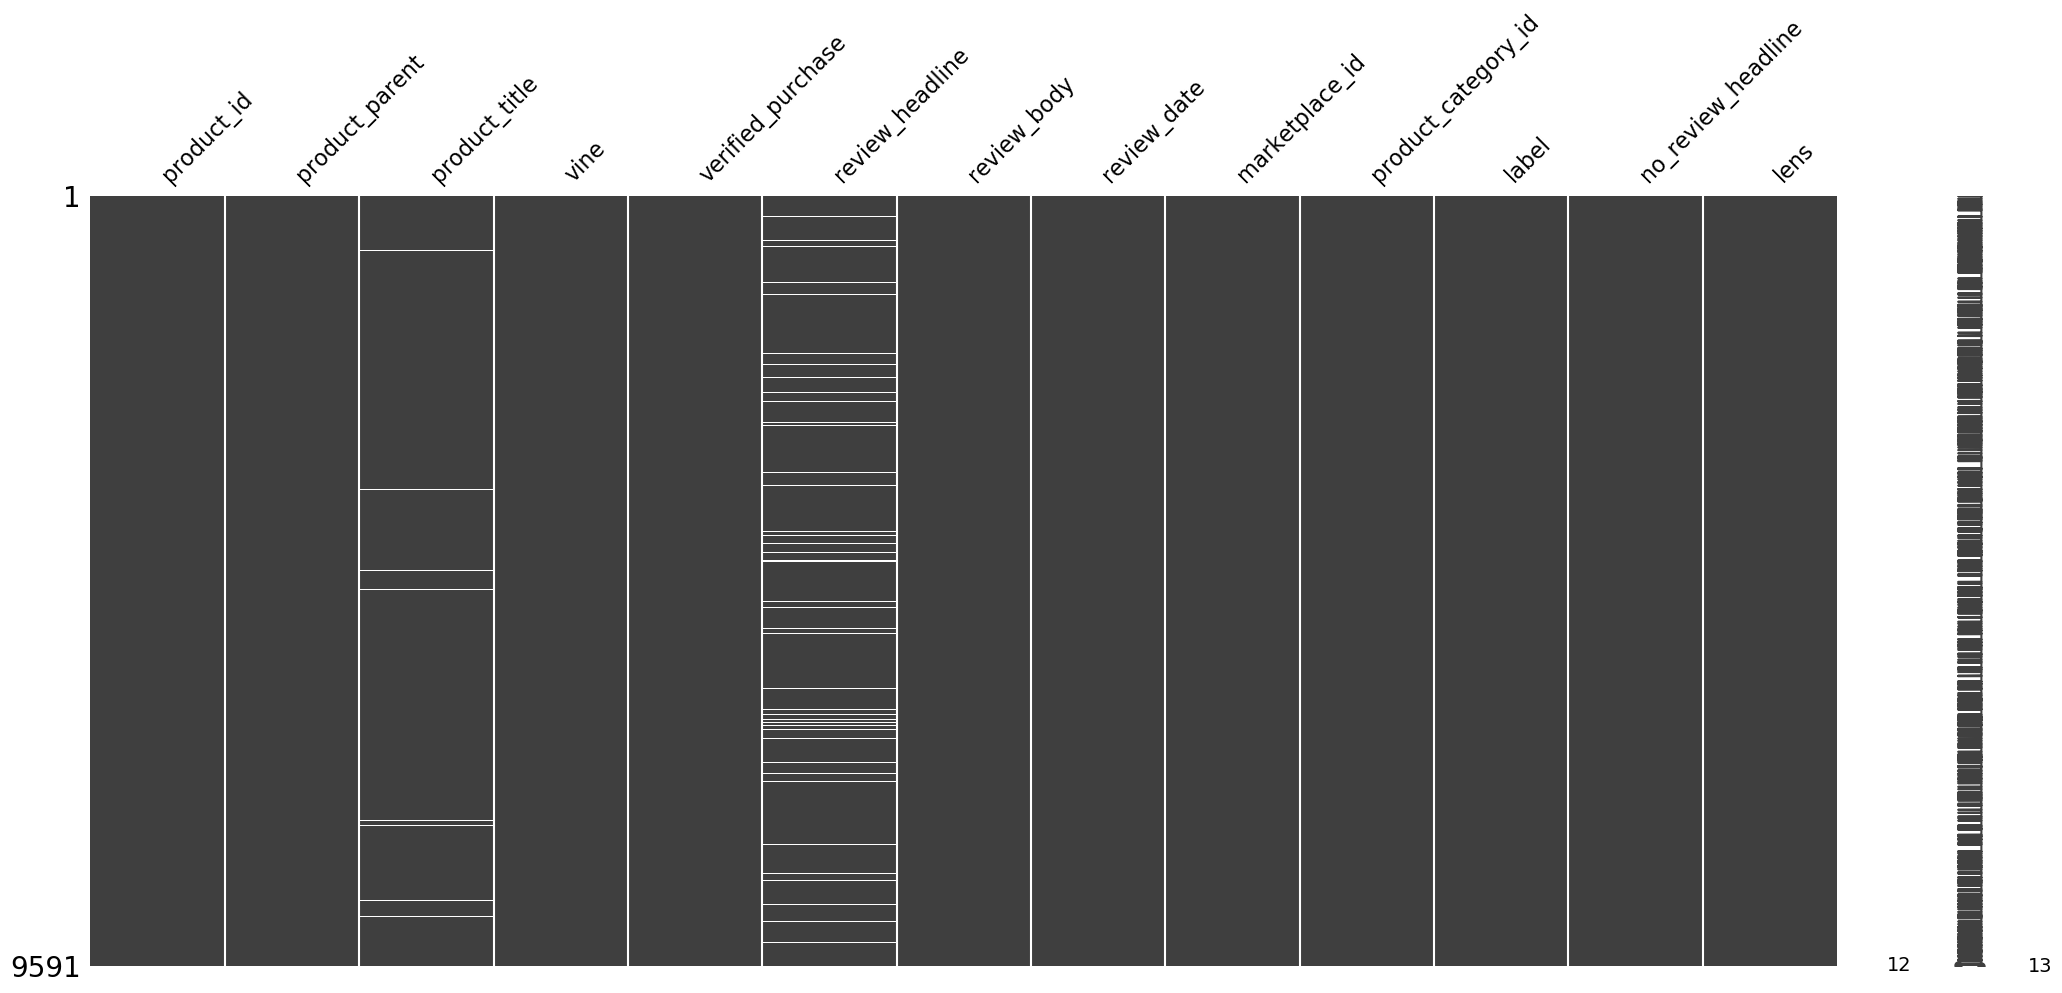

In [58]:
import missingno as mso

mso.matrix(df)
plt.show()

In [96]:
def translator_fn(review):
    translated = tlx.translate(review)
    return translated

In [130]:
def truncate_long_reviews(review):
    return review[:5000]

In [149]:
# df['translated_review'] = df['review_body'].apply(lambda x: translator_fn(x[:4500]))

KeyboardInterrupt: 

In [9]:
df.head()

,product_id,product_parent,product_title,vine,verified_purchase,review_headline,review_body,review_date,marketplace_id,product_category_id,label,no_review_headline,lens,Year,Month,Day
,,,,,,,,,,,,,,,,
9,B001N2MZT8,903886718,Green Zone [DVD],False,True,green zone,I found at first it was a little difficult to ...,2010-11-15,1,3,False,False,450,2010,11,15
11,B00GCBVE0Q,282740618,Le secret de Green Knowe,False,True,NaN,J'ai aimé cette histoire. Les acteurs - et sur...,2014-11-23,2,3,False,True,153,2014,11,23
19,1423165691,883799517,A Disney Sketchbook.,False,False,okay mais...,est-ce une coincidence que la plupart des prin...,2012-12-22,0,0,False,False,246,2012,12,22
33,0061091480,623343977,Your Erroneous Zones,False,False,Arrogant,Wayne Dyer is a popular american personal grow...,2009-07-21,0,0,True,False,325,2009,7,21
34,B00HZ4CYOY,647510225,König der Mathematik Junior,False,True,Tolle Mathe App...,.....unsere Kids mögen diese Art des Lernens. ...,2015-06-01,0,1,False,False,156,2015,6,1


In [81]:
df["review_date"] = pd.to_datetime(df["review_date"])
df = df[df['review_date'].notna()]
df['Year'] = pd.to_datetime(df['review_date']).dt.year
df['Month'] = pd.to_datetime(df['review_date']).dt.month
df['Day'] = pd.to_datetime(df['review_date']).dt.day

## Modeling part starts here

In [82]:
qad_df = df.copy()
# delete_columns(qad_df, columns_to_delete=['product_id', 'product_title', 'vine', 'review_headline', 'review_body', 'review_date'])
# qad_df = qad_df[[ 'verified_purchase', 'category_name', 'country_name', 'label', 'has_review_headline', 'lens']]
# qad_df = qad_df[[ 'verified_purchase', 'label', 'has_review_headline', 'lens']]
# qad_df = qad_df[[ 'verified_purchase', 'label', 'no_review_headline', 'lens']]
# qad_df = qad_df[['verified_purchase', 'lens', 'product_category_id', 'label', 'no_review_headline', 'Year', 'Month', 'Day']]
qad_df = qad_df[['verified_purchase', 'lens', 'product_category_id', 'label', 'no_review_headline', 'Year', 'readability']]
# qad_df = qad_df[['verified_purchase', 'lens', 'product_category_id', 'label', 'no_review_headline', 'Year', 'readability', 'marketplace_id']]

In [83]:
qad_df['label'] = qad_df['label'].apply(lambda x: 1 if x else 0)

In [25]:
qad_df.sort_index(axis=0, inplace=True)

In [79]:
qad_df.head()

,review_body,label
,,
1,I took ages to sign up for this and finally su...,0
2,J'ai acheté un jeu de Lego (Lego Creator - 102...,0
3,Ich fand das Buch sehr gut. Der Protagonist ve...,0
4,Sadly I am still stuggling to get into this bo...,1
5,Wir finden diese Serie super klasse und spanne...,1


In [18]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

In [123]:
qad_df = encode_and_bind(encode_and_bind(qad_df, 'country_name'), 'category_name')

,verified_purchase,label,has_review_headline,lens,country_name_DE,country_name_FR,country_name_UK,category_name_Automotive,category_name_Baby,category_name_Books,...,category_name_PC,category_name_Personal_Care_Appliances,category_name_Shoes,category_name_Sports,category_name_Toys,category_name_Video,category_name_Video DVD,category_name_Video Games,category_name_Watches,category_name_Wireless
,,,,,,,,,,,,,,,,,,,,,
9,True,False,False,450,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
145,True,False,False,110,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
256,False,True,False,249,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
938,True,False,False,113,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1097,True,False,False,41,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [43]:
# qad_df['verified_purchase'] = qad_df['verified_purchase'].apply(lambda x: 1 if x else 0)
# qad_df['label'] = qad_df['label'].apply(lambda x: 1 if x else 0)
# qad_df['no_review_headline'] = qad_df['verified_purchase'].apply(lambda x: 1 if x else 0)

In [67]:
qad_df.head()

,index,review_body,label
0,1,I took ages to sign up for this and finally su...,0
1,2,J'ai acheté un jeu de Lego (Lego Creator - 102...,0
2,3,Ich fand das Buch sehr gut. Der Protagonist ve...,0
3,4,Sadly I am still stuggling to get into this bo...,1
4,5,Wir finden diese Serie super klasse und spanne...,1


In [84]:
y = qad_df.pop('label')
X = qad_df

In [53]:
X.head()

,verified_purchase,lens,product_category_id,no_review_headline,Year,readability
,,,,,,
9,True,450,3,False,2010,8.625069
11,True,153,3,True,2014,5.788214
19,False,246,0,False,2012,10.846429
33,False,325,0,False,2009,14.264211
34,True,156,1,False,2015,12.706667


In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [86]:
    from xgboost import XGBClassifier
    from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
    from sklearn.metrics import roc_auc_score
    from sklearn.model_selection import StratifiedKFold
    from lightgbm import LGBMClassifier

In [87]:
params_xg = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        # 'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [3, 4, 5, 7],
        'learning_rate': [0.1, 0.01, 0.05],
        'n_estimators': [200, 1500, 2000],
        # 'bootstrap': [False, True],

        }

params_rf = {
        'max_depth': [3, 4, 5, 7, 10],
        'n_estimators': [200, 500, 1000, 1500, 2000],
        

        }

        # bootstrap=True, ccp_alpha=0.0, class_weight=None,
        #                criterion='gini', max_depth=None, max_features='auto',
        #                max_leaf_nodes=None, max_samples=None,
        #                min_impurity_decrease=0.0, min_impurity_split=None,
        #                min_samples_leaf=1, min_samples_split=2,
        #                min_weight_fraction_leaf=0.0, n_estimators=1000,
        #                n_jobs=None, oob_score=False, random_state=None,
        #                verbose=0, warm_start=False)

In [121]:
params_lgbm = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": [200, 500, 1000, 1500, 2000],
        "learning_rate": [0.1, 0.01, 0.005],
        "num_leaves": [5, 10, 20, 50, 100],
        "max_depth": [5, 7, 10],
        "min_data_in_leaf": [2, 5, 7],
        "lambda_l1": [1, 5, 10, 20, 50],
        "lambda_l2": [1, 5, 10, 20, 50],
        'feature_fraction': [0.1, 0.9],
        'bagging_fraction': [0.8, 1],
    }

In [122]:
# clf = XGBClassifier(learning_rate=0.005, n_estimators=1200, objective='binary:logistic',
#                     silent=True, nthread=-1)

# clf = RandomForestClassifier()
clf = LGBMClassifier()

folds = 4
param_comb = 20

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(clf, param_distributions=params_lgbm, n_iter=param_comb, scoring='accuracy', n_jobs=-1, 
                                   cv=skf.split(X_train,y_train), 
                                   verbose=3, random_state=1001)

# gcv = GridSearchCV(clf, param_grid=params_xg, scoring='accuracy', n_jobs=-1, 
#                                    cv=skf.split(X_train,y_train), 
#                                    verbose=3)
random_search.fit(X_train, y_train)

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   22.9s finished


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x000001FA24DC20C8>,
                   error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None...
                   param_distributions={'bagging_fraction': [0.8, 1],
                                        'feature_fraction': [0.1, 0.9],
                                        'lambda_l1':

In [123]:
y_pred = random_search.predict(X_test)

In [124]:
accuracy_score(y_test, y_pred)

0.7477899115964639

In [125]:
test_df = pd.read_csv('test_hidden.csv')
validation_df = pd.read_csv('validation_hidden.csv')

In [126]:
test_df = preprocess(test_df, is_train=False)

In [127]:
validation_df = preprocess(validation_df, is_train=False)

In [128]:
# df['number_of_words'] = df['review_body'].apply(lambda x: len(x.split()))
def count_sentence(data_df, text):
    pun_sen = ['.', '!', '?']
    text_col = data_df[text]
    sentence_counts = []
    for i in text_col:
        sentence_count = []
        for j in pun_sen:
            count_a = i.count(j)
            sentence_count.append(count_a)
        sentence_counts.append(sum(sentence_count))
    data_df['number_of_sentences'] = sentence_counts
    return data_df['number_of_sentences']
# df['number_of_sentences'] = count_sentence(df, 'review_body')
punctuation = ['!','"','#','$','%','&',"'",'(',')','*','+',',','-','.','/',':',';','<','=','>','?','@','[','\\',']','^','_','`','{','|','}','~','``',"''",'--']

def count_characters(data_df):
    reviewcharacters = []
    text_col = data_df['review_body']
    for i in text_col:
        a = dict(Counter(i))
        b = {k:v for k, v in a.items() if k not in punctuation}
        c = sum(list(b.values()))
        reviewcharacters.append(c)
    data_df['number_of_characters'] = reviewcharacters
    return data_df['number_of_characters']
# df['number_of_characters'] = count_characters(df)
def readability(data_df):
    wordperSen = []
    charperWord = []
    reviewRead = []
    len_df = len(data_df)
    a = list(data_df['number_of_words'])
    b = list(data_df['number_of_sentences'])
    c = list(data_df['number_of_characters'])
    for i in range(len_df):
        if b[i] == 0:
            wordperSen.append(0)
        else:
            j = a[i] / b[i]
            wordperSen.append(j)
        if a[i] == 0:
            charperWord.append(0)
        else:
            l = c[i] / a[i]
            charperWord.append(l)
        ari = 4.71 * charperWord[i] + 0.5 * wordperSen[i] - 21.43
        reviewRead.append(ari)
    data_df['readability'] = reviewRead
    return data_df['readability']
# df['readability'] = readability(df)

In [129]:
validation_df['number_of_words'] = validation_df['review_body'].apply(lambda x: len(x.split()))
test_df['number_of_words'] = test_df['review_body'].apply(lambda x: len(x.split()))

validation_df['number_of_sentences'] = count_sentence(validation_df, 'review_body')
test_df['number_of_sentences'] = count_sentence(test_df, 'review_body')

validation_df['number_of_characters'] = count_characters(validation_df)
test_df['number_of_characters'] = count_characters(test_df)

validation_df['readability'] = readability(validation_df)
test_df['readability'] = readability(test_df)

In [130]:
validation_df["review_date"] = pd.to_datetime(validation_df["review_date"])
# df = df[df['review_date'].notna()]
validation_df['Year'] = pd.to_datetime(validation_df['review_date']).dt.year
validation_df['Month'] = pd.to_datetime(validation_df['review_date']).dt.month
validation_df['Day'] = pd.to_datetime(validation_df['review_date']).dt.day

test_df["review_date"] = pd.to_datetime(test_df["review_date"])
# df = df[df['review_date'].notna()]
test_df['Year'] = pd.to_datetime(test_df['review_date']).dt.year
test_df['Month'] = pd.to_datetime(test_df['review_date']).dt.month
test_df['Day'] = pd.to_datetime(test_df['review_date']).dt.day

In [131]:
COLUMNS = qad_df.columns.tolist()

In [132]:
test_df = test_df[COLUMNS]

In [133]:
validation_df = validation_df[COLUMNS]

In [134]:
y_pred_test = random_search.predict(test_df)

In [135]:
y_pred_val = random_search.predict(validation_df)

In [136]:
y_pred_test = np.array(y_pred_test, dtype=bool)
y_pred_val = np.array(y_pred_val, dtype=bool)

In [137]:
y_pred_test = y_pred_test.astype(str)
y_pred_val = y_pred_val.astype(str)

In [138]:
y_pred_test

array(['True', 'True', 'False', ..., 'False', 'False', 'False'],
      dtype='<U5')

In [139]:
np.savetxt("quick_and_dirty_test2.txt", y_pred_test, delimiter=",", fmt='%s')
np.savetxt("quick_and_dirty_val2.txt", y_pred_val, delimiter=",", fmt='%s')